Index(['un', 'i-a [ua]', 'i9', 'i11', 'intensity'], dtype='object')
Index(['U-n [V]', 'Ia [uA]', 'I9 [uA]', 'I13 [uA]'], dtype='object')
      un  i-a [ua]     i9   i11 intensity          v     sigma  ln_sigma_div_v
0  770.0      99.0  11.45  0.88        Φ1  59.230769  3.607127       -2.798530
1  762.0      90.0  10.25  0.81        Φ1  58.615385  3.557291       -2.801998
2  750.0      80.0   9.20  0.75        Φ1  57.692308  3.502380       -2.801681
3  740.0      70.0   8.10  0.68        Φ1  56.923077  3.451342       -2.802938
4  728.0      60.0   7.10  0.61        Φ1  56.000000  3.411648       -2.798156


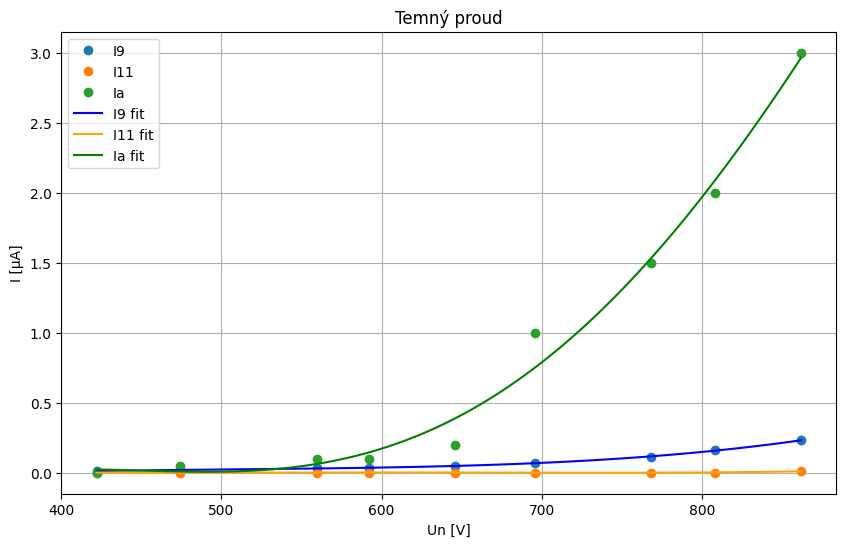

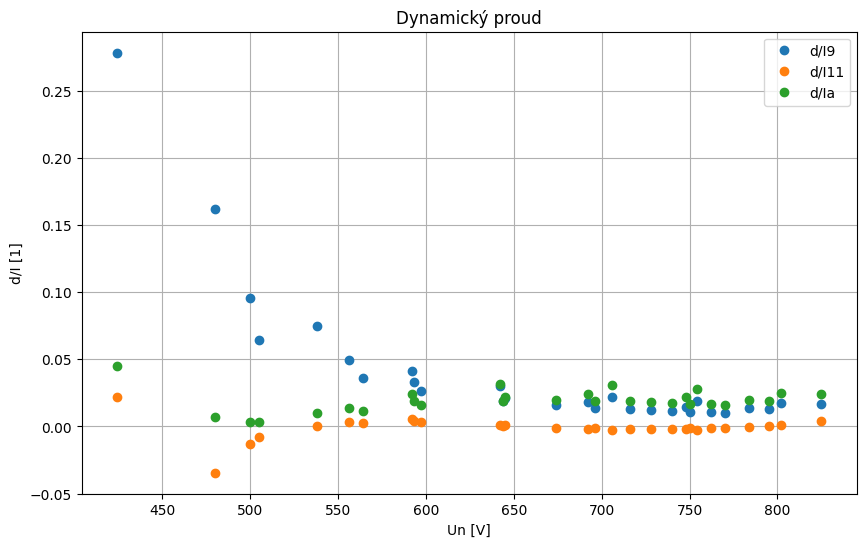

      un   i-a [ua]         i9       i11 intensity          v     sigma  \
0  770.0  97.447027  11.332500  0.880754        Φ1  59.230769  3.607127   
1  762.0  88.548771  10.139420  0.810945        Φ1  58.615385  3.557291   
2  750.0  78.694611   9.099061  0.751110        Φ1  57.692308  3.502380   
3  740.0  68.809866   8.006452  0.681152        Φ1  56.923077  3.451342   
4  728.0  58.940575   7.014592  0.611112        Φ1  56.000000  3.411648   

   ln_sigma_div_v   deltai9  deltai11    deltia      d/i9     d/i11      d/ia  
0       -2.798530  0.117500 -0.000754  1.552973  0.010368 -0.000856  0.015937  
1       -2.801998  0.110580 -0.000945  1.451229  0.010906 -0.001166  0.016389  
2       -2.801681  0.100939 -0.001110  1.305389  0.011093 -0.001478  0.016588  
3       -2.802938  0.093548 -0.001152  1.190134  0.011684 -0.001691  0.017296  
4       -2.798156  0.085408 -0.001112  1.059425  0.012176 -0.001820  0.017974  


In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from uncertainties import ufloat

# Load all three CSV files
lvl1 = pd.read_csv("lvl1.csv")
lvl2 = pd.read_csv("lvl2.csv")
lvl3 = pd.read_csv("lvl3.csv")

u750 = pd.read_csv("u750.csv")
u750 = u750.dropna()

u600 = pd.read_csv("u600.csv")
u600 = u600.dropna()

u750.rename(columns={"Klin uroven": "phi","I-a [uA]": "ia", "I-9 [uA]": "i9", "I-13 [uA]": "i11"}, inplace=True)
u600.rename(columns={"Klin uroven": "phi","I-a [uA]": "ia", "I-9 [uA]": "i9", "I-13 [uA]": "i11"}, inplace=True)


# Add intensity level as a column
lvl1["intensity"] = "Φ1"
lvl2["intensity"] = "Φ2"
lvl3["intensity"] = "Φ3"
lvl1,lvl2,lvl3 = lvl1.dropna(),lvl2.dropna(),lvl3.dropna()

# Combine all into one dataframe
df_all = pd.concat([lvl1, lvl2, lvl3], ignore_index=True)

# Standardize column names
df_all.columns = [col.strip().lower() for col in df_all.columns]
df_all.rename(columns={"un [v]": "un", "i-9 [ua]": "i9", "i-13 [ua]": "i11"}, inplace=True)
print(df_all.columns)

# Calculate V = Un / 13 (napětí mezi dynodami)
df_all["v"] = df_all["un"] / 13

# Calculate sigma = sqrt(I11 / I9)
df_all["sigma"] = np.sqrt(df_all["i9"] / df_all["i11"])

# Calculate ln(sigma / V)
df_all["ln_sigma_div_v"] = np.log(df_all["sigma"] / df_all["v"])

tp = pd.read_csv("temnyproud.csv")
tp = tp.dropna()
print(tp.columns)
print(df_all.head())

#plot ia i9 i11 vs un
plt.figure(figsize=(10, 6))
plt.plot(tp["U-n [V]"], tp["I9 [uA]"], "o", label="I9")
plt.plot(tp["U-n [V]"], tp["I13 [uA]"], "o", label="I11")
plt.plot(tp["U-n [V]"], tp["Ia [uA]"], "o", label="Ia")
#polynomial 3rd degree fit for I9 and I11
coeffs_i9 = np.polyfit(tp["U-n [V]"], tp["I9 [uA]"], 4)
coeffs_i11 = np.polyfit(tp["U-n [V]"], tp["I13 [uA]"], 4)
coeffs_ia = np.polyfit(tp["U-n [V]"], tp["Ia [uA]"], 4)

x_fit = np.linspace(tp["U-n [V]"].min(), tp["U-n [V]"].max(), 100)
y_fit_i9 = np.polyval(coeffs_i9, x_fit)
y_fit_i11 = np.polyval(coeffs_i11, x_fit)
y_fit_ia = np.polyval(coeffs_ia, x_fit)

plt.plot(x_fit, y_fit_i9, label="I9 fit", color="blue")
plt.plot(x_fit, y_fit_i11, label="I11 fit", color="orange")
plt.plot(x_fit, y_fit_ia, label="Ia fit", color="green")

plt.xlabel("Un [V]")
plt.ylabel("I [µA]")
plt.title("Temný proud")
plt.legend()
plt.grid()
plt.show()
plt.close()
df_all["deltai9"] = np.polyval(coeffs_i9, df_all["un"])
df_all["deltai11"] = np.polyval(coeffs_i11, df_all["un"])
df_all["deltia"] = np.polyval(coeffs_ia, df_all["un"])

df_all["i9"] = df_all["i9"]- np.polyval(coeffs_i9, df_all["un"])
df_all["i11"] = df_all["i11"]- np.polyval(coeffs_i11, df_all["un"])
df_all["i-a [ua]"] = df_all["i-a [ua]"]- np.polyval(coeffs_ia, df_all["un"])

df_all["d/i9"] = df_all["deltai9"] / df_all["i9"]
df_all["d/i11"] = df_all["deltai11"] / df_all["i11"]
df_all["d/ia"] = df_all["deltia"] / df_all["i-a [ua]"]

plt.figure(figsize=(10, 6))
plt.plot(df_all["un"], df_all["d/i9"], "o", label="d/I9")
plt.plot(df_all["un"], df_all["d/i11"], "o", label="d/I11")
plt.plot(df_all["un"], df_all["d/ia"], "o", label="d/Ia")
plt.xlabel("Un [V]")
plt.ylabel("d/I [1]")
plt.title("Dynamický proud")
plt.legend()
plt.grid()
plt.show()


print(df_all.head())

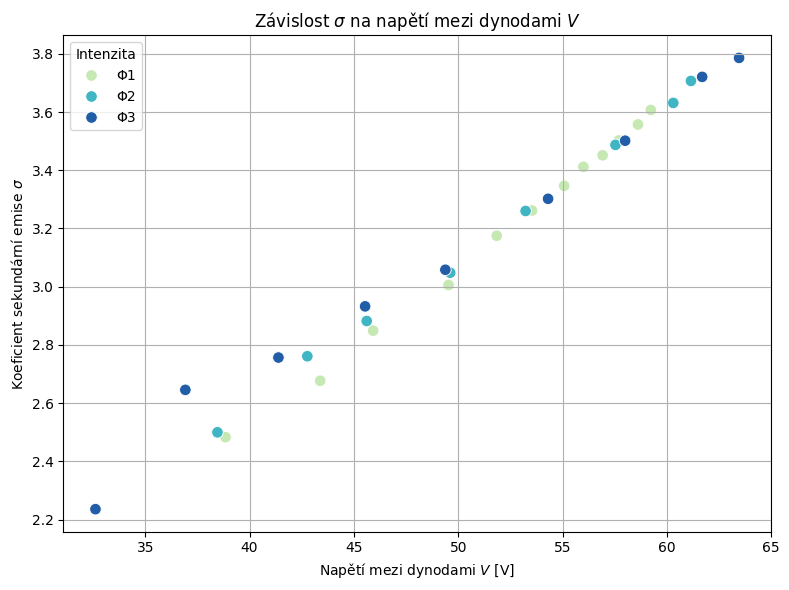

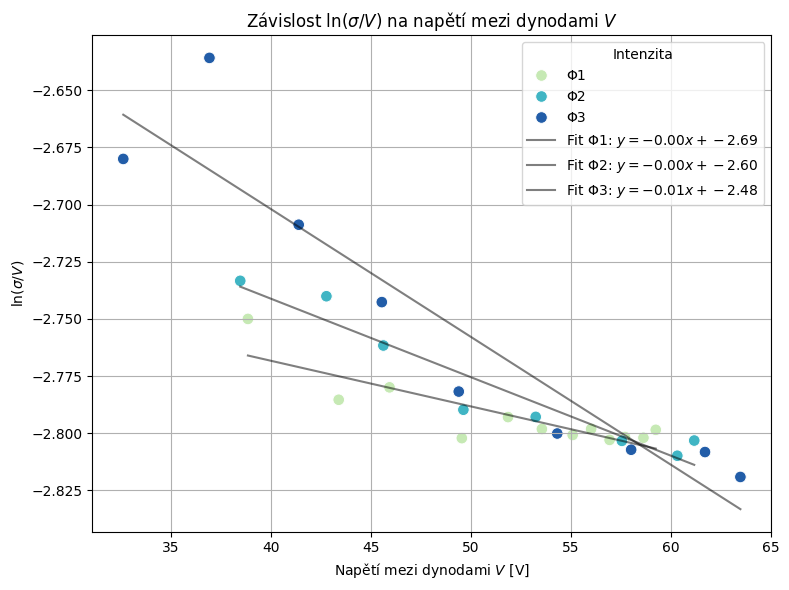

In [96]:
# Create plots for sigma = f(V) and ln(sigma/V) = f(V), color-coded by intensity level

import matplotlib.pyplot as plt
import seaborn as sns

# Plot 1: sigma vs V
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_all, x="v", y="sigma", hue="intensity", s=70, palette="YlGnBu")
plt.title(r"Závislost $\sigma$ na napětí mezi dynodami $V$")
plt.xlabel(r"Napětí mezi dynodami $V$ [V]")
plt.ylabel(r"Koeficient sekundární emise $\sigma$")
plt.grid(True)
plt.legend(title="Intenzita")
plt.tight_layout()
plt.show()

# Plot 2: ln(sigma/V) vs V
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_all, x="v", y="ln_sigma_div_v", hue="intensity", s=70, palette="YlGnBu")
#linear fitting of all data
x = df_all["v"] 
y = df_all["ln_sigma_div_v"]
for i in df_all["intensity"].unique():
    mask = df_all["intensity"] == i
    x_i = df_all.loc[mask, "v"]
    y_i = df_all.loc[mask, "ln_sigma_div_v"]
    coeffs_i = np.polyfit(x_i, y_i, 1)
    y_fit_i = np.polyval(coeffs_i, x_i)
    plt.plot(x_i, y_fit_i, label=f"Fit {i}: $y = {coeffs_i[0]:.2f}x + {coeffs_i[1]:.2f}$", color="black", linestyle="-", alpha=0.5)
plt.title(r"Závislost $\ln(\sigma/V)$ na napětí mezi dynodami $V$")
plt.xlabel(r"Napětí mezi dynodami $V$ [V]")
plt.ylabel(r"$\ln(\sigma / V)$")
plt.grid(True)
plt.legend(title="Intenzita")
plt.tight_layout()
plt.show()


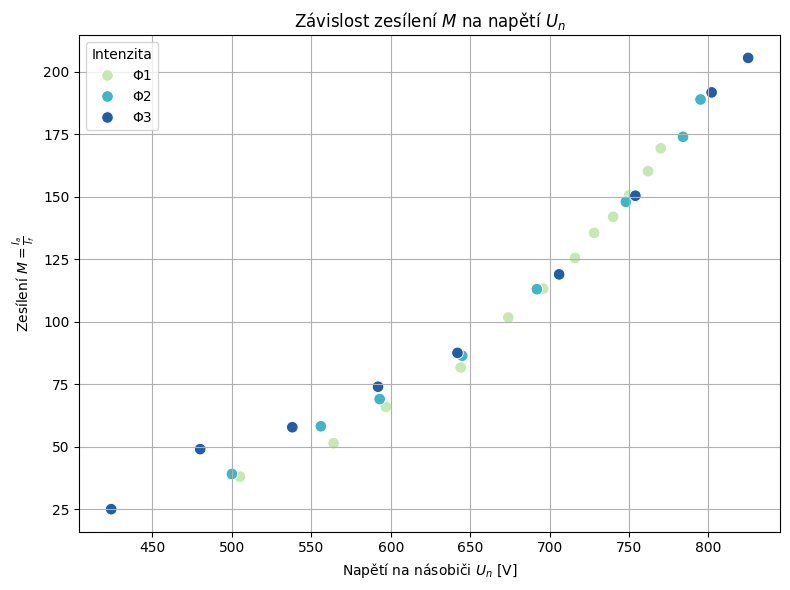

Slope: 0.0001226+/-0.0000014
Intercept: (-1.0+/-0.6)e-06
Zesílení k: 8157.97


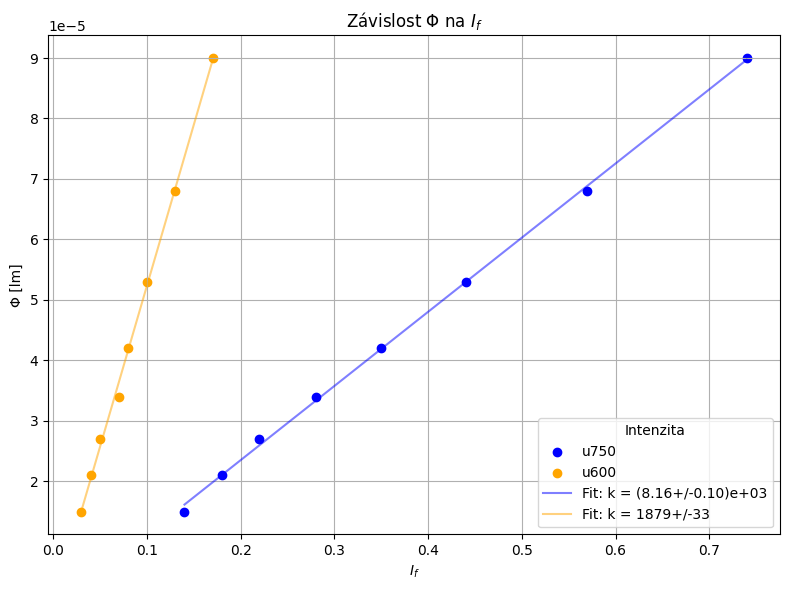

   phi    ia    i9   i11      phi2      sigma    If            k
0  1.0  10.0  1.43  0.17  0.000090   8.411765  0.17  1888.888889
1  2.0   8.0  1.12  0.13  0.000068   8.615385  0.13  1911.764706
2  3.0   6.4  0.88  0.10  0.000053   8.800000  0.10  1886.792453
3  4.0   5.5  0.71  0.08  0.000042   8.875000  0.08  1904.761905
4  5.0   4.2  0.52  0.07  0.000034   7.428571  0.07  2058.823529
5  6.0   4.0  0.47  0.05  0.000027   9.400000  0.05  1851.851852
6  7.0   3.0  0.38  0.04  0.000021   9.500000  0.04  1904.761905
7  8.0   2.3  0.31  0.03  0.000015  10.333333  0.03  2000.000000
   phi    ia    i9   i11      phi2      sigma    If            k
0  1.0  78.8  9.20  0.74  0.000090  12.432432  0.74  8222.222222
1  2.0  62.0  7.10  0.57  0.000068  12.456140  0.57  8382.352941
2  3.0  48.0  5.50  0.44  0.000053  12.500000  0.44  8301.886792
3  4.0  38.2  4.38  0.35  0.000042  12.514286  0.35  8333.333333
4  5.0  32.0  3.60  0.28  0.000034  12.857143  0.28  8235.294118
5  6.0  26.0  2.86  0.22 

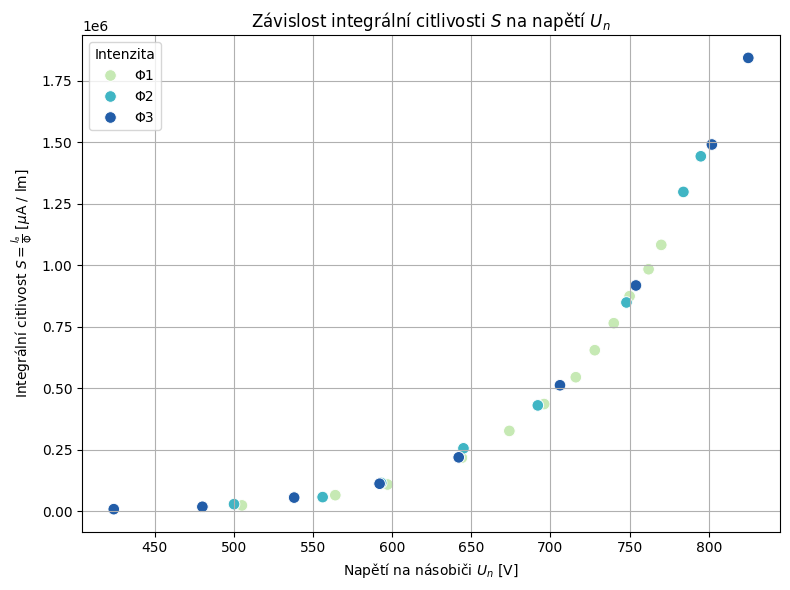

In [117]:
from uncertainties import ufloat
from uncertainties.umath import *

# Výpočet fotoproudu If pomocí sigma a I9
df_all["if"] = df_all["i9"] / df_all["sigma"]

# Výpočet zesílení M = Ia / If
df_all["m"] = df_all["sigma"]**4

df_all["if"] = df_all["i-a [ua]"]/df_all["m"]

# Výpočet integrální citlivosti fotonásobiče S = Ia / Φ
# Pozor: nemáme hodnoty Φ, ale pokud bychom Φ vyjádřili pomocí If = k*Φ, pak:
# S = M * k — v tomto kroku vypočteme zatím pouze M závislost na napětí

# Vykreslení M = f(Un)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_all, x="un", y="m", hue="intensity", s=70, palette="YlGnBu")
plt.title(r"Závislost zesílení $M$ na napětí $U_n$")
plt.xlabel(r"Napětí na násobiči $U_n$ [V]")
plt.ylabel(r"Zesílení $M = \frac{I_a}{I_f}$")
plt.grid(True)
plt.legend(title="Intenzita")
plt.tight_layout()
plt.show()

# Hodnoty Φ [Lm] podle grafu (odhadnuto z obrázku, ve stejném řádu 1e-4)
# Poloha 1 → Φ ≈ 0.92e-4
# Poloha 2 → Φ ≈ 0.72e-4
# Poloha 3 → Φ ≈ 0.58e-4

phi_values = {
    "Φ1": 0.9e-4,
    "Φ2": 0.68e-4,
    "Φ3": 0.53e-4,
    1: 0.9e-4,
    2: 0.68e-4,
    3: 0.53e-4,
    4: 0.42e-4,
    5: 0.34e-4,
    6: 0.27e-4,
    7: 0.21e-4,
    8: 0.15e-4,
}

# Přiřazení Φ do dataframe podle intenzity
df_all["phi"] = df_all["intensity"].map(phi_values)
u750["phi2"] =u750["phi"].map(phi_values)
u600["phi2"] =u600["phi"].map(phi_values)
u750["sigma"] = u750["i9"] / u750["i11"]
u600["sigma"] = u600["i9"] / u600["i11"]
u750["If"] = u750["i9"] / u750["sigma"]
u600["If"] = u600["i9"] / u600["sigma"]

u750["k"] = u750["If"]/u750["phi2"]
u600["k"] = u600["If"]/u600["phi2"]


#plt sigma vs phi
plt.figure(figsize=(8, 6))
plt.scatter(u750["If"], u750["phi2"], label="u750", color="blue")
plt.scatter(u600["If"], u600["phi2"], label="u600", color="orange")

#fit linear phi = If/k
# Fit with uncertainties
coeffs, cov = np.polyfit(u750["If"], u750["phi2"], 1, cov=True)
slope = ufloat(coeffs[0], np.sqrt(cov[0, 0]))
intercept = ufloat(coeffs[1], np.sqrt(cov[1, 1]))

# Generate fit line
x_fit = np.linspace(u750["If"].min(), u750["If"].max(), 100)
y_fit = slope.n * x_fit + intercept.n

# Print uncertainties
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
plt.plot(x_fit, y_fit, label=f"Fit: k = {1/slope}", color="blue", linestyle="-", alpha=0.5)
k = 1/coeffs[0]
print(f"Zesílení k: {k:.2f}")

coeffs, cov = np.polyfit(u600["If"], u600["phi2"], 1, cov=True)
slope = ufloat(coeffs[0], np.sqrt(cov[0, 0]))
intercept = ufloat(coeffs[1], np.sqrt(cov[1, 1]))

x_fit = np.linspace(u600["If"].min(), u600["If"].max(), 100)
y_fit = slope.n * x_fit + intercept.n


plt.plot(x_fit, y_fit, label=f"Fit: k = {1/slope}", color="orange", linestyle="-", alpha=0.5)
plt.xlabel(r"$I_f$ $\mu$ A")
plt.ylabel(r"$\Phi$ [lm]")
plt.title(r"Závislost $\Phi$ na $I_f$")

plt.ylabel(r"Φ [lm]")
plt.xlabel(r"$I_f$")
plt.title(r"Závislost $\Phi$ na $I_f$")
plt.grid(True)
plt.legend(title="Intenzita")
plt.tight_layout()
plt.show()




print(u600)
print(u750)
# Výpočet integrální citlivosti S = Ia / Φ
df_all["s"] = df_all["i-a [ua]"] / df_all["phi"]

# Vykreslení S = f(Un)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_all, x="un", y="s", hue="intensity", s=70, palette="YlGnBu")
plt.title(r"Závislost integrální citlivosti $S$ na napětí $U_n$")
plt.xlabel(r"Napětí na násobiči $U_n$ [V]")
plt.ylabel(r"Integrální citlivost $S = \frac{I_a}{\Phi}$ [$\mu$A / lm]")
plt.grid(True)
plt.legend(title="Intenzita")
plt.tight_layout()
plt.show()


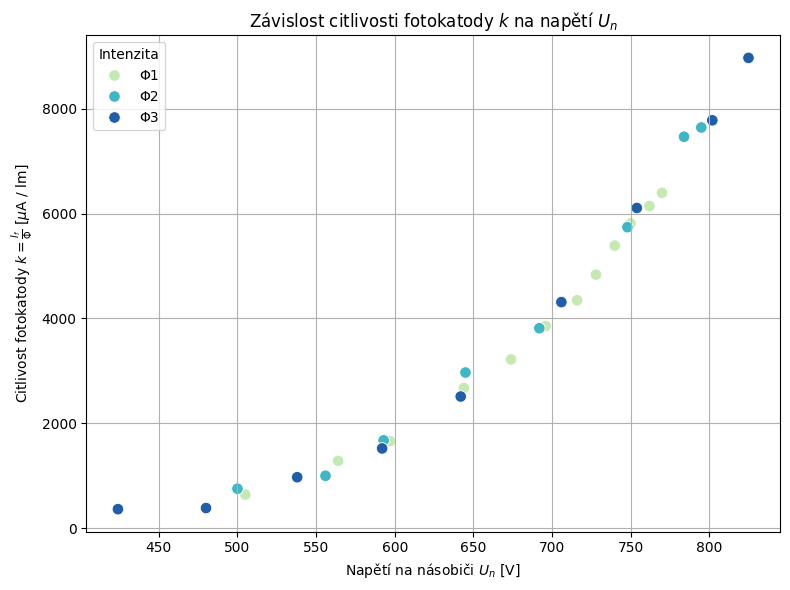

In [87]:
#integralni citlivost fotokatody k = If / Φ
# Vykreslení k = f(Un)
df_all["k"] = df_all["if"] / df_all["phi"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_all, x="un", y="k", hue="intensity", s=70, palette="YlGnBu")
plt.title(r"Závislost citlivosti fotokatody $k$ na napětí $U_n$")
plt.xlabel(r"Napětí na násobiči $U_n$ [V]")
plt.ylabel(r"Citlivost fotokatody $k = \frac{I_f}{\Phi}$ [$\mu$A / lm]")
plt.grid(True)
plt.legend(title="Intenzita")
plt.tight_layout()
plt.show()
